# ガウス過程の周辺尤度最大化

In [1]:
%matplotlib inline 
from IPython.core.display import display, Math, Latex

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from sympy import *
import sympy
from sympy.plotting import plot, plot3d, plot3d_parametric_line, plot3d_parametric_surface
import matplotlib.figure
init_printing()
#from math import *
from interval import interval
from interval import imath
import sys
from pprint import pprint


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
from numpy.random import seed
import pandas as pd

## 1. Log marginal likelihood の定義
- $\mathbf{\theta} = (\sigma_f, l, \sigma_n)$
- $ K_{y(pq)} = kernel(\mathbf{x}_p, \mathbf{x}_q, \mathbf{\theta}) + \sigma_n\delta_{pq}$
- $\log(p(\mathbf{y} | X, \mathbf{\theta})) = - \dfrac{1}{2} \mathbf{y}^TK^{-1}_y\mathbf{y} - \dfrac{1}{2} \log{|K_y|} - \dfrac{n}{2} \log{2\pi}$
- $f(\mathbf{\theta}) =  - \log(p(\mathbf{y} | X, \mathbf{\theta}))$
    - $f(\mathbf{\theta})$を最小化する

In [2]:
_X_num= 20
_X_dim =  2
_X = symbols('x1:%d' % (_X_num * _X_dim + 1))
theta = l, sigma_f, sigma_n = symbols('l sigma_f sigma_n')

### 1.1 データの読み込み
- 'generate_psuedo_data_for_regression.ipynb'で作成した 'dump/data_df.pkl'

In [3]:
data_df = pd.read_pickle('dump/data_df.pkl').sample(n=2, random_state=282)
print(len(data_df))
X = np.array(list(data_df.X))
print(X.shape)
y = np.array(data_df.y)
print(y)

2
(2, 2)
[ 25.46030817  26.03251248]


### 1.2 $K_y$を定義

In [4]:
def kernel(p, q, i, j):
    """
    p,q: np.array
    """
    def rbf(p, q):
        dist = np.sum((p - q) ** 2)
        return exp(-(1. / l**2) * dist)
    
    ans =  (sigma_f**2) * rbf(p, q) + (sigma_n**2) * int(i == j) # 対角成分のみnoiseを追加
    return ans


2


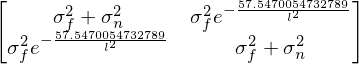

In [5]:
K = Matrix([[kernel(p, q, i, j) for j,q in enumerate(X)] for i,p in enumerate(X)])
print(len(y))
if len(y) < 5:
    display(K)

In [6]:
# import time
# def calc_time_of_inverse_matrix(X, size):
#     _X = X[:size]
#     K = Matrix([[kernel(p, q, i, j) for j,q in enumerate(_X)] for i,p in enumerate(_X)])
#     start = time.time()
#     K_inv = K.inv()
#     end = time.time()
#     print('sample size: {}, time: {:.2f}[sec]'.format(size, end - start))
    
# for i in range(1, 5+1):
#     calc_time_of_inverse_matrix(X, i)

### 1.3 $\log(p(\mathbf{y} | X, \mathbf{\theta}))$の計算

In [7]:
y = Matrix(y)

def get_log_prob_expr(K, y): 
    K_inv = K.inv('LU')
    first_tem = (1/2.) * (y.T)*(K_inv)*(y)
    second_term = (1/2.) * Matrix([K.det()]).applyfunc(log)
    third_term = Matrix([(len(y)/2.) * log(2*pi)])
    log_prob = - first_tem -  second_term - third_term
    return log_prob[0, 0]


log_prob_expr = get_log_prob_expr(K, y)

## 2. $f(\theta)$の最小化

### 2.1 評価関数 $f(\theta)$ の定義
- $f(\mathbf{\theta}) = -\log(p(\mathbf{y} | X, \mathbf{\theta}))$
    - $f(\mathbf{\theta})$を最小化する

In [8]:
f_expr = - log_prob_expr
f = lambdify(theta, f_expr, modules=(imath))
interval_val = (interval[0.1, 1.7], interval[0.1, 2.6], interval[0.1,1.2])

In [9]:
interval_val = (interval[0.615, 0.92], interval[2.08, 2.2], interval[0.65,0.96])
f(*interval_val)
#f(1,1,1)

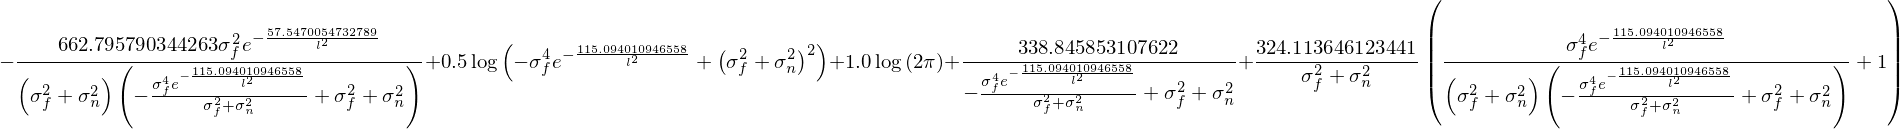

In [10]:
if len(y) < 3:
    display(f_expr)

In [11]:
import sys
sys.setrecursionlimit(10000)

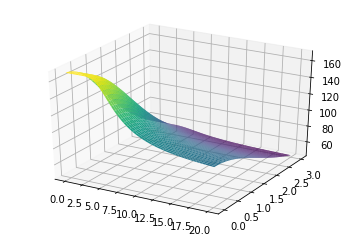

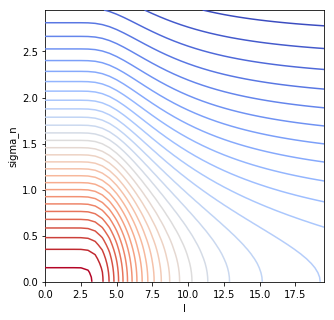

In [12]:
g_expr = f_expr.subs([(sigma_f, 2.0)])
l_min, l_max = (0.01, 20)
sigma_n_min, sigma_n_max = (0, 3)

plot3d(g_expr, (l, l_min, l_max), (sigma_n, sigma_n_min, sigma_n_max))

x = np.arange(l_min, l_max, 0.5) # length scale
y = np.arange(sigma_n_min, sigma_n_max, 0.05) # noise 
X, Y =  np.meshgrid(x, y)

g = lambdify((l, sigma_n), g_expr, np)
Z = np.array([g(*x) for x in np.array([X.flatten(), Y.flatten()]).T ]).reshape(X.shape)

plt.figure(figsize=(5,5))
plt.contour(X, Y, Z, 30, zorder=1000, shading='gouraud', cmap=plt.cm.coolwarm)
plt.xlabel('l')
plt.ylabel('sigma_n')

### 2.2 $\dfrac{\partial}{\partial \theta}f(\theta)$の計算

In [13]:
df_expr = [[f_expr.diff(_theta)] for _theta in theta]
print(type(df_expr))
df = lambdify(theta, df_expr, modules=(imath, {'ImmutableDenseMatrix': list}))
print(type(df))

<class 'list'>
<class 'function'>


### 2.3 $\dfrac{\partial^{2}}{\partial \theta^{2}}f(\theta)$の計算

In [14]:
ddf_expr = hessian(f_expr, theta)
print(type(ddf_expr))
ddf = lambdify(theta, ddf_expr, modules=(imath, {'ImmutableDenseMatrix': list}))
print(type(ddf))

<class 'sympy.matrices.dense.MutableDenseMatrix'>
<class 'function'>
